In [ ]:
# !pip install --upgrade pip
# !sudo apt-get install swig build-essential  python3-dev
 
!pip install -r requirements.txt
# !pip install gymnasium[box2d]

In [29]:
#
import torch

from ddpg_torch import AgentDDPG
from sac_torch import AgentSAC
import gym
# from SAC import SAC_Agent
from ReplayBuffer import RandomBuffer, device
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os, shutil
import argparse
from Adapter import *
#
import gym
import numpy as np
from utils import plotLearning

import glob
from PIL import Image

from utils import show_video, convert_gif
from gym.wrappers.monitoring.video_recorder import VideoRecorder


from base64 import b64encode

In [ ]:
!rm -r requirements.txt
!pip freeze > requirements.txt

### BidepalWalker

In [30]:
# name_env = 'LunarLanderContinuous-v2'
name_env ="BipedalWalker-v3"
env = gym.make(name_env)

print([*env.observation_space.shape],*env.action_space.shape)

input_dims = [*env.observation_space.shape]
n_actions = env.action_space.shape[0]

print(input_dims,n_actions)


def make_gif(frame_folder,name):
      frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
      frame_one = frames[0]
      frame_one.save(os.path.join(frame_folder,f"{name}.gif"), format="GIF", append_images=frames,
                save_all=True, duration=100, loop=0)
def render_mp4(videopath: str) -> str:
    """
    Gets a string containing a b4-encoded version of the MP4 video
    at the specified path.
    """
    mp4 = open(videopath, 'rb').read()
    base64_encoded_mp4 = b64encode(mp4).decode()
    return f'<video width=400 controls><source src="data:video/mp4;' \
          f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

[24] 4
[24] 4


/home/rd-vrar/GreenHouse/.venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/rd-vrar/GreenHouse/.venv/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
torch.cuda.is_available()

True

In [4]:
kwargs = {
        "state_dim": input_dims[0],
        "action_dim": n_actions,
        "gamma": .99,
        "hid_shape": (256,128),
        "a_lr": 3e-5,
        "c_lr": 3e-5,
        "batch_size":128,
        "alpha":0.12,
        "adaptive_alpha":True
    }

agentSAC = AgentSAC(**kwargs, agent_dir=os.path.join(os.getcwd(),name_env,'SAC'))

if not os.path.exists(os.path.join(os.getcwd(),name_env,'SAC')):
    os.mkdir(os.path.join(os.getcwd(),name_env,'SAC'))
BriefEnvName = ['BWv3', 'BWHv3', 'Lch_Cv2', 'PV0', 'Humanv2', 'HCv2']

EnvIdex = 0

random_seed = 1

In [5]:
timenow = str(datetime.now())[0:-10]
timenow = ' ' + timenow[0:13] + '_' + timenow[-2::]
writepath = os.path.join(os.getcwd(),name_env,'SAC','runs',f'SAC_{BriefEnvName[EnvIdex]}' + timenow)
if os.path.exists(writepath):
    shutil.rmtree(writepath)
writer= SummaryWriter(log_dir=writepath)
print(f'writepath: {writepath}')

writepath: /home/rd-vrar/GreenHouse/BipedalWalker-v3/SAC/runs/SAC_BWv3 2023-09-25 10_33


#### rewrite train

In [11]:
import types

In [12]:
env.reset()

array([ 2.7458926e-03,  1.0166979e-05, -1.3257136e-03, -1.6000066e-02,
        9.2477098e-02,  3.0775599e-03,  8.5980332e-01, -1.0442530e-03,
        1.0000000e+00,  3.2796379e-02,  3.0774472e-03,  8.5354030e-01,
       -2.0939938e-03,  1.0000000e+00,  4.4081339e-01,  4.4581950e-01,
        4.6142212e-01,  4.8954949e-01,  5.3410202e-01,  6.0246021e-01,
        7.0914787e-01,  8.8593054e-01,  1.0000000e+00,  1.0000000e+00],
      dtype=float32)

In [13]:
 def train(
        self,env,total_steps,EnvIdex,write,writer,
        EnvName=['BipedalWalker-v3','BipedalWalkerHardcore-v3','LunarLanderContinuous-v2','Pendulum-v0','Humanoid-v2','HalfCheetah-v2'],
        update_every:int=50,
        eval_interval:int=int(1e3),
        save_interval:int=int(2.5e3),# opt.save_interval  #in steps
        random_seed:int=42,
        plot:bool=True,
        plot_path:str= os.path.join(os.getcwd(),'plots',"BipedalWalker-v3")):

            if not os.path.exists(plot_path):
                    # Create a new directory because it does not exist
                    os.makedirs(plot_path)
            replay_buffer = RandomBuffer([*env.observation_space.shape][0], env.action_space.shape[0], True, max_size=int(1e6))
            max_action = float(env.action_space.high[0])
            steps_per_epoch = env._max_episode_steps
            #Interaction config:

            write = True # opt.write

            start_steps = 5 * steps_per_epoch #in steps
            update_after = 2 * steps_per_epoch #in steps
            eval_env = env


            s, done, current_steps = env.reset(), False, 0


            # print(f's={s}; done = {done};')
            for t in range(total_steps):
                current_steps += 1
                '''Interact & trian'''

                if t < start_steps:
                    #Random explore for start_steps
                    act = env.action_space.sample() #act∈[-max,max]
                    a = Action_adapter_reverse(act,max_action) #a∈[-1,1]
                else:
                    # print(f'[AgentSAC] total_steps = {total_steps}; [Action_adapter];s={s[0]}; t = {t}')
                    a = self.select_action(s, deterministic=False, with_logprob=False) #a∈[-1,1]
                    act = Action_adapter(a,max_action) #act∈[-max,max]

                s_prime, r, done, info = env.step(act)#s_prime, r, done, info = env.step(act)
                dead = Done_adapter(r, done, current_steps, EnvIdex)
                r = Reward_adapter(r, EnvIdex)
                replay_buffer.add(s, a, r, s_prime, dead)
                s = s_prime


                # 50 environment steps company with 50 gradient steps.
                # Stabler than 1 environment step company with 1 gradient step.
                if t >= update_after and t % update_every == 0:
                    for j in range(update_every):
                        # print(f'[AgentSAC] [LEARNING: STEP] = {j} from {update_every} steps')
                        self.learn(replay_buffer)

                '''save model'''
                if (t + 1) % save_interval == 0:
                    self.save(t + 1)

                '''record & log'''
                if (t + 1) % eval_interval == 0:
                    score = evaluate_policy(eval_env, self, False, steps_per_epoch, max_action, EnvIdex)
                    if write:
                        writer.add_scalar('ep_r', score, global_step=t + 1)
                        writer.add_scalar('alpha', self.alpha, global_step=t + 1)
                    print('EnvName:', EnvName[EnvIdex], 'seed:', random_seed, 'totalsteps:', t+1, 'score:', score)
                if done:
                    s, done, current_steps = env.reset(), False, 0
                self.score_history.append(r)
                if plot:
                     if (t + 1) % save_interval == 0:
                        filename = f'{t+1}.png'
                        plotLearning(self.score_history,os.path.join(plot_path,filename),window=100)


            env.close()
            eval_env.close()

agentSAC.train = types.MethodType(train, agentSAC)

In [14]:
def evaluate_policy(env, model, render, steps_per_epoch, max_action, EnvIdex):
    scores = 0
    turns = 3#opt.eval_turn
    for j in range(turns):
        s, done, ep_r = env.reset(), False, 0
        while not done:
            # Take deterministic actions at test time
            # print(f'[evaluate_policy] s= {s}')
            a = model.select_action(s, deterministic=True, with_logprob=False)
            act = Action_adapter(a, max_action)  # [0,1] to [-max,max]
            s_prime, r, done, info = env.step(act)#s_prime, r, done, info = env.step(act)
            # r = Reward_adapter(r, EnvIdex)
            ep_r += r
            s = s_prime
            if render:
                env.render()
        # print(ep_r)
        scores += ep_r
    return scores/turns

#### train

In [15]:
agentSAC.actor.device

device(type='cuda', index=0)

In [16]:
import gym
print(gym.__version__)

0.25.2


In [17]:
agentSAC.load(1587500)

...loading checkpoint...


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 1000 score: 327.620061726035
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 2000 score: 327.79125592073086
...saving checkpoint...
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 3000 score: 327.58252189310133
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 4000 score: -89.53488285074546
...saving checkpoint...
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 5000 score: -103.61142137110899
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 6000 score: -98.90343877734449
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 7000 score: -102.85609765924836
...saving checkpoint...
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 8000 score: -102.84450161573947
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 9000 score: -73.91812844438554
...saving checkpoint...
EnvName: BipedalWalker-v3 seed: 42 totalsteps: 10000 score: -61.73389532021472
EnvName: BipedalWalker-v3 seed: 

KeyboardInterrupt: 

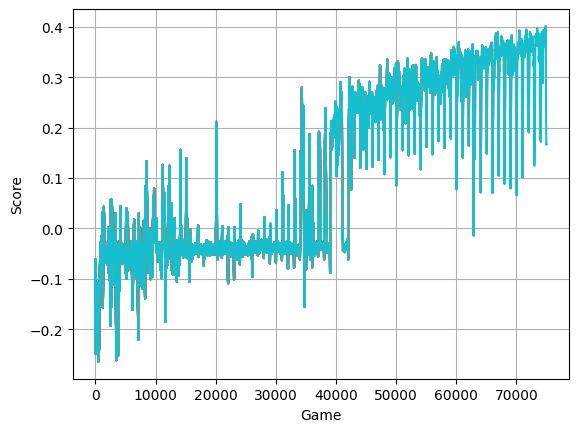

In [18]:
%load_ext tensorboard
agentSAC.train(
    env=env,total_steps=int(5e6-1587500),EnvIdex = 0,write=True,
    writer= writer,
    plot=True,
    plot_path=os.path.join(os.getcwd(),name_env,'SAC','plots'))

In [ ]:
make_gif(os.path.join(os.getcwd(),name_env,'SAC','plots'),name_env)
from IPython.display import Image

Image(open(os.path.join(os.getcwd(),name_env,'SAC','plots',name_env+ '.gif'),'rb').read())
# img = mpimg.imread(os.path.join(os.getcwd(),'plots',name_env,name_env+ '.gif'))#"/content/animationBrownianMotion2d.gif")

#### Visulize

In [20]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

display = Display(visible=False, size=(1400, 900))
_ = display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [31]:
env_copy = env

##### BEFORE

In [22]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = f"before_training.mp4"

video = VideoRecorder(env, before_training)


env_copy.reset()


for i in range(6000):
  env_copy.render()
  video.capture_frame()
  action = env_copy.action_space.sample()
  # action = agent.choose_action(observation)
  observation, reward, done, info = env_copy.step(action)
  # Not printing this time
  #print("step", i, observation, reward, done, info)

video.close()
env_copy.close()

/home/rd-vrar/GreenHouse/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment BipedalWalker-v3 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/home/rd-vrar/GreenHouse/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/home/rd-vrar/GreenHouse/.venv/lib/python3.10/site-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't ca

In [23]:
html = render_mp4(before_training)
HTML(html)

##### AFTER

In [32]:
from os import listdir
from os.path import isfile, join
model_path = os.path.join(os.getcwd(),name_env,'SAC','model')
onlyfiles = [f for f in listdir(model_path) if isfile(join(model_path, f))]
onlyfiles[0],onlyfiles[2]

import re
# actor pattern
actor_pattern = '((sac_actor)(\d+)\.(pth))'
q_critic_pattern = '((sac_q_critic)(\d+)\.(pth))'
actor_strings = list(
    map(
        lambda x: re.match(actor_pattern,x).groups(),
        list(
          filter(
              lambda x: re.match(actor_pattern, x),
              onlyfiles)
          )
        )
    )
print(f'max_episode: {max(list(map(lambda x:float(x[2]),actor_strings)))}')
print(sorted(actor_strings,key=lambda x:x[2]))
max_episode = int(max(list(map(lambda x:float(x[2]),actor_strings))))

max_episode: 75000.0
[('sac_actor67500.pth', 'sac_actor', '67500', 'pth'), ('sac_actor70000.pth', 'sac_actor', '70000', 'pth'), ('sac_actor72500.pth', 'sac_actor', '72500', 'pth'), ('sac_actor75000.pth', 'sac_actor', '75000', 'pth')]


In [33]:
kwargs = {
        "state_dim": input_dims[0],
        "action_dim": n_actions,
        "gamma": .99,
        "hid_shape": (256,128),
        "a_lr": 3e-5,
        "c_lr": 3e-5,
        "batch_size":128,
        "alpha":0.12,
        "adaptive_alpha":True
    }

agentSAC = AgentSAC(**kwargs, agent_dir=os.path.join(os.getcwd(),name_env,'SAC'))

agentSAC.load(episode=max_episode)

...loading checkpoint...


In [34]:
after_training = f"SAC_{name_env}_training.mp4"

video = VideoRecorder(env, after_training)


# returns an initial observation
observation=env.reset()

game_played = 0
for i in range(6000):
  env_copy.render()
  video.capture_frame()
  # action = env_copy.action_space.sample()
  action = agentSAC.select_action(observation,False,False)
  observation, reward, done, info = env_copy.step(action)
  # if done:
  #   observation=env.reset()
  #   game_played += 1
  # if game_played <= 1000:
  #   break
  # Not printing this time
  #print("step", i, observation, reward, done, info)

video.close()
env_copy.close()

/home/rd-vrar/GreenHouse/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [35]:
html = render_mp4(after_training)
HTML(html)